## Imports and Setup

In [1]:
import os
import sys
import time
import copy
import re

sys.path.insert(0, '../utils')
import data_utils

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

SEED = 42
np.random.seed(SEED)

%matplotlib inline
TM_pal_categorical_3 = ('#ef4631', '#10b9ce', '#ff9138')
sns.set(style='white', font_scale=1.25, palette=TM_pal_categorical_3)

%load_ext autoreload
%autoreload 2

## File Locations

In [3]:
# Google Cloud Storage
bucket_name = 'tm-geospatial'
directory = 'poverty-prediction-datasets'

# Destination paths
nightlights_file = '../data/nightlights.csv'
nightlights_unstacked_file = '../data/nightlights_unstacked.csv'
nightlights_bins_file = '../data/nightlights_bins.csv'

nightlights_train_file = '../data/nightlights_train.csv'
nightlights_train_bal_file = '../data/nightlights_train_bal.csv'
nightlights_val_file = '../data/nightlights_val.csv'

dhs_indicators_file = '../data/dhs_indicators.csv'
satellite_images_dir = '../data/images/'
report_file = '../data/images/report/report.csv'

## Download Datasets

In [4]:
# Download from Google Cloud Storage
data_utils.download_from_bucket('nightlights.csv', directory, nightlights_file, bucket_name);

../data/nightlights.csv successfully downloaded


## Night Time Lights (NTL) Dataset EDA

In [5]:
# Load nighttime lights data
nightlights = pd.read_csv(nightlights_file)
print('Number of images to download: {} \n'.format(nightlights.ID.nunique()))
nightlights.tail(3)

Number of images to download: 134540 



,ID,DHSCLUST,ntllon,ntllat,ntl2016,pop_sum
134537,323239,PH201700000726,122.683334,12.341666,0.00000,483.555064
134538,323240,PH201700000726,122.687501,12.362499,0.17369,141.463403
134539,323241,PH201700000726,122.687501,12.358333,0.11054,443.106126


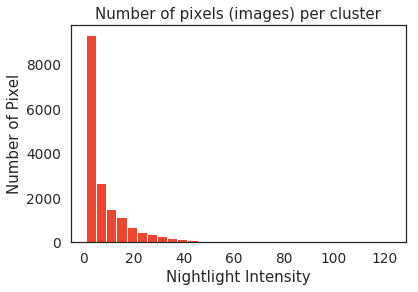

In [6]:
# Sanity check: Number of pixels (images) per cluster
data_utils.plot_hist(
    nightlights[nightlights['ntl2016'] > 1]['ntl2016'],
    title='Number of pixels (images) per cluster', 
    x_label='Nightlight Intensity', 
    y_label='Number of Pixel'
)

In [7]:
# Unstack dataset so that each row consists of a unique (cluster, lat, lon) tuple 
nightlights = data_utils.unstack_clusters(nightlights)
nightlights.to_csv(nightlights_unstacked_file)
print("\n\nNumber of pixels (including duplicates belonging to different clusters): {}".format(len(nightlights)))

100%|██████████| 134540/134540 [00:15<00:00, 8446.43it/s]




Number of pixels (including duplicates belonging to different clusters): 173580


In [11]:
# Sanity check number of DHS clusters and night time lights summary statistics
print("Number of unique clusters in night lights dataset: ", nightlights['DHSCLUST'].nunique())
nightlights['ntl2016'].describe()

Number of unique clusters in night lights dataset:  1214


count    173580.000000
mean          2.055890
std           7.030332
min           0.000000
25%           0.000000
50%           0.000000
75%           0.324230
max         122.432310
Name: ntl2016, dtype: float64

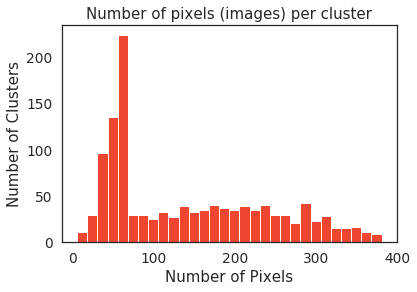

In [10]:
# Sanity check: Number of pixels (images) per cluster
data_utils.plot_hist(
    nightlights.groupby('DHSCLUST').count()['ntl2016'],
    title='Number of pixels (images) per cluster', 
    x_label='Number of Pixels', 
    y_label='Number of Clusters'
)

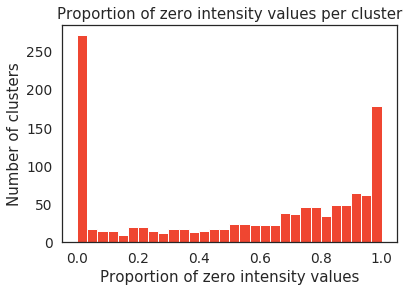

Around 150 clusters have ~100% zero night light intensity values (total darkness).
Percent of zero intensity pixels in dataset:  0.6599550639474594


In [12]:
nightlights_zero = nightlights.groupby(['DHSCLUST', 'ntl2016']).size().unstack(fill_value=0)
data_utils.plot_hist(
    nightlights_zero[0.0]/nightlights_zero.sum(axis=1),
    title='Proportion of zero intensity values per cluster', 
    x_label='Proportion of zero intensity values', 
    y_label='Number of clusters'
)
print("Around 150 clusters have ~100% zero night light intensity values (total darkness).")

# Get proportion of zero intenity levels in the dataset
percent_zeros = nightlights[nightlights['ntl2016'] == 0].shape[0]/len(nightlights)
print("Percent of zero intensity pixels in dataset: ", percent_zeros)

Shape of average night lights dataframe:  (1214, 2)


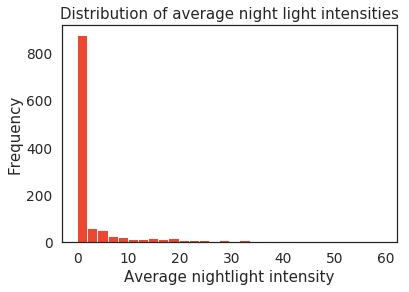

In [22]:
# Get average nighttime lights per cluster
nightlights_avg = pd.DataFrame(nightlights.groupby(['DHSCLUST'])['ntl2016'].mean()).reset_index()
print("Shape of average night lights dataframe: ", nightlights_avg.shape)
data_utils.plot_hist(
    nightlights_avg['ntl2016'],
    title='Distribution of average night light intensities', 
    x_label='Average nightlight intensity', 
    y_label='Frequency'
)

Shape of population dataframe:  (1214, 2)


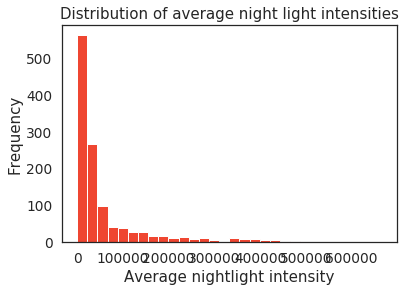

In [23]:
# Get sum of population per cluster
pop_sum = pd.DataFrame(nightlights.groupby(['DHSCLUST'])['pop_sum'].sum()).reset_index()
print("Shape of population dataframe: ", pop_sum.shape)
data_utils.plot_hist(
    pop_sum['pop_sum'],
    title='Distribution of average night light intensities', 
    x_label='Average nightlight intensity', 
    y_label='Frequency'
)

## Load DHS Dataset

In [24]:
# Load DHS indicators
dhs_indicators = pd.read_csv(dhs_indicators_file)

# Merge average night time lights data with DHS indicators
nightlights_avg = nightlights_avg.merge(dhs_indicators, left_on='DHSCLUST', right_on='Cluster number')
pop_sum = pop_sum.merge(dhs_indicators, left_on='DHSCLUST', right_on='Cluster number')

print("Number of unique clusters in DHS data merged with NTL data: ", nightlights_avg['DHSCLUST'].nunique())
print("Number of unique clusters in DHS data merged with pop data: ", pop_sum['DHSCLUST'].nunique())

Number of unique clusters in DHS data merged with NTL data:  1213
Number of unique clusters in DHS data merged with pop data:  1213


## Correlations between Average Nighttime Lights and Socioeconomic Indicators

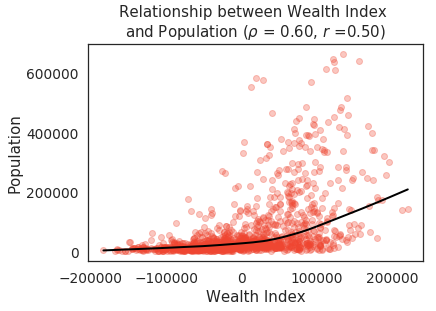

In [25]:
data_utils.plot_regplot(pop_sum, 'Wealth Index', 'Population', 'pop_sum')

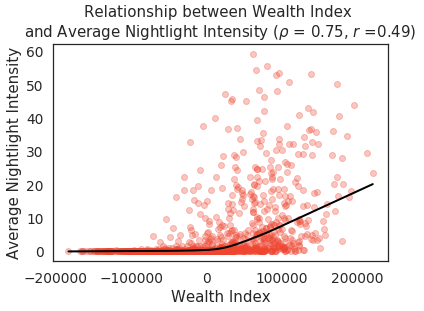

In [22]:
data_utils.plot_regplot(nightlights_avg, 'Wealth Index')

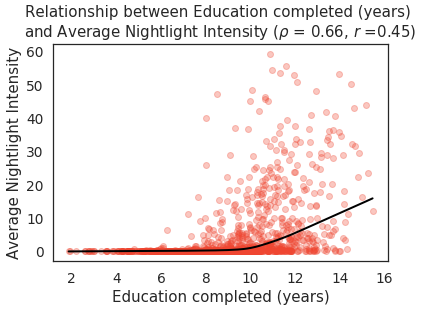

In [24]:
data_utils.plot_regplot(nightlights_avg, 'Education completed (years)')

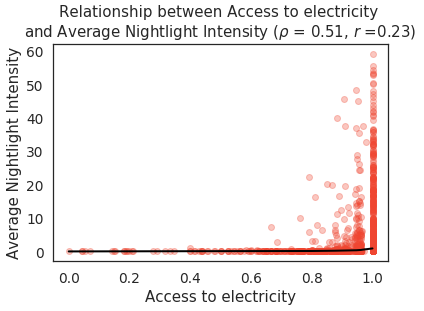

In [25]:
data_utils.plot_regplot(nightlights_avg, 'Access to electricity')

/home/issa/.local/lib/python3.5/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/home/issa/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/issa/.local/lib/python3.5/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


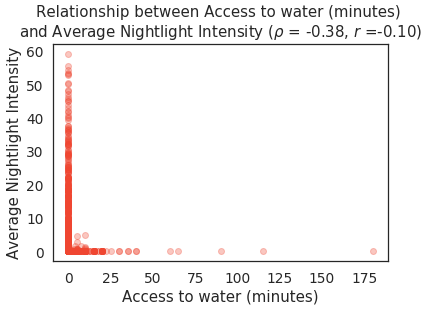

In [26]:
data_utils.plot_regplot(nightlights_avg, 'Access to water (minutes)')

## Binning Night Light Intensities

In [4]:
# Load dataset
nightlights = pd.read_csv(nightlights_file)
nightlights.head(3)

,ID,DHSCLUST,ntllon,ntllat,ntl2016,pop_sum
0,0,"PH201700000387, PH201700000395",120.554167,18.212500,0.49878,446.725863
1,3,"PH201700000395, PH201700000387",120.554167,18.200000,0.29817,16.787817
2,4,"PH201700000387, PH201700000395",120.554167,18.195833,0.63710,151.090350


### Gaussian Mixture Model

{0: 0.0, 1: 1.83839, 2: 122.43231000000002, 3: 0.4707, 4: 9.16312}
{0: 'low', 1: 'medium', 2: 'high', 3: 'low medium', 4: 'high medium'}


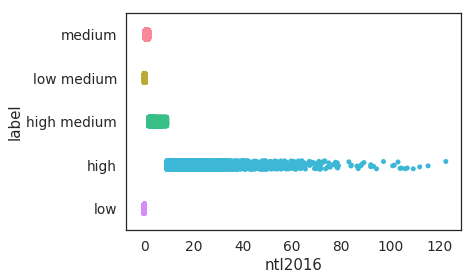

In [32]:
bin_labels = ['low', 'low medium', 'medium', 'high medium', 'high']
nightlights = data_utils.gaussian_mixture_model(nightlights, n_components=5, bin_labels=bin_labels)
ax = sns.stripplot(x="ntl2016", y='label', data=nightlights)
plt.show()

In [35]:
for label in bin_labels:
    print(
        "Number of {} intensity pixels: {}".format(label, nightlights[nightlights['label'] == label]['ntl2016'].count())
    )

Number of low intensity pixels: 94680
Number of low medium intensity pixels: 16169
Number of medium intensity pixels: 10785
Number of high medium intensity pixels: 7844
Number of high intensity pixels: 5062


### Ad Hoc Label Assignment

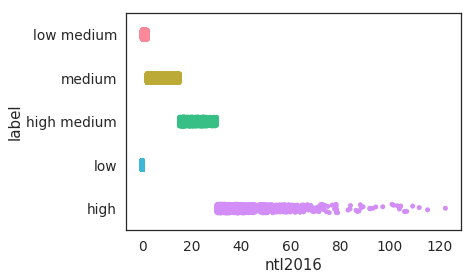

In [5]:
bin_caps = [0, 2, 15, 30]
bin_labels = ['low', 'low medium', 'medium', 'high medium', 'high']
nightlights['label'] = nightlights['ntl2016'].apply(lambda x: data_utils.ad_hoc_binning(x, bin_caps, bin_labels))
ax = sns.stripplot(x="ntl2016", y='label', data=nightlights)
plt.show()

In [9]:
nightlights[nightlights['label'] == 'high medium']['ntl2016'].describe()

count    2161.000000
mean       20.726912
std         4.231244
min        15.009130
25%        17.022590
50%        19.820690
75%        23.909240
max        29.994180
Name: ntl2016, dtype: float64

In [14]:
for label in bin_labels:
    print("Number of {} intensity pixels: {}".format(label, nightlights[nightlights['label'] == label]['ntl2016'].count()))

Number of low intensity pixels: 94680
Number of low medium intensity pixels: 27415
Number of medium intensity pixels: 9389
Number of high medium intensity pixels: 2161
Number of high intensity pixels: 895


In [15]:
nightlights.to_csv(nightlights_bins_file, index=False)

## Download Google Static Maps (GSM) Images

In [17]:
nightlights = pd.read_csv(nightlights_bins_file)
print('Total number of images: ', nightlights.shape[0])
nightlights['label'].value_counts()

Total number of images:  134540


low            94680
low medium     27415
medium          9389
high medium     2161
high             895
Name: label, dtype: int64

In [18]:
nightlights['label'].value_counts()/nightlights.shape[0]

low            0.703731
low medium     0.203768
medium         0.069786
high medium    0.016062
high           0.006652
Name: label, dtype: float64

In [ ]:
# Uncomment to download data
#os.environ['GEO_AI_API_KEY'] = "INSERT API KEY HERE"
#os.environ['GEO_AI_SECRET_KEY'] = "INSERT SECRET KEY HERE"

#import data_download
#data_download.get_satellite_images_with_labels(nightlights_bins_file, satellite_images_dir)

## Balancing Nighttime Lights Intensity Levels

In [5]:
# Load nighttime lights dataset
nightlights = pd.read_csv(nightlights_bins_file)
print('Total number images downloaded: ', len(nightlights))

# Shuffle nighttime lights dataset
nightlights = nightlights.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Train/Validation Split
train, val = data_utils.train_val_split(nightlights, train_size=0.9)

# Save Validation Set
val.to_csv(nightlights_val_file, index=False)

print('Size of training set: ', len(train))
print('Size of validation set: ', len(val))

Size of training set:  121086
Size of validation set:  13454


In [7]:
# Check class distribution of train set
train['label'].value_counts()

low            85150
low medium     24731
medium          8467
high medium     1945
high             793
Name: label, dtype: int64

In [8]:
# Check class distribution of validation set
val['label'].value_counts()

low            9530
low medium     2684
medium          922
high medium     216
high            102
Name: label, dtype: int64

In [15]:
# Resample/ upsample training set
train_balanced = data_utils.balance_dataset(train, size=30000)
print('Number of images in training set (balanced): ', len(train_balanced))

Number of images in training set (balanced):  150000


In [16]:
# Sanity check: training set class distribution
train_balanced['label'].value_counts()

low            30000
high medium    30000
medium         30000
low medium     30000
high           30000
Name: label, dtype: int64

In [ ]:
# Save balanced training set
train_balanced.to_csv(nightlights_train_bal_file, index=False)

In [ ]:
# Load image locations
report = pd.read_csv(report_file)

In [19]:
data_utils.train_val_split_images(val, report, satellite_images_dir, phase='val')

100%|██████████| 13454/13454 [05:02<00:00, 29.07it/s]


In [21]:
data_utils.train_val_split_images(train_balanced, report, satellite_images_dir, phase='train')

100%|██████████| 150000/150000 [34:11<00:00, 73.13it/s] 
